In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
!ls ../input/nlp-getting-started/

sample_submission.csv  test.csv  train.csv


## BERT Tokenization
Ref: https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py

In [3]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [49]:
import numpy as np
import pandas as pd
import os
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [5]:
train = pd.read_csv('../input/nlp-getting-started//train.csv')
test = pd.read_csv('../input/nlp-getting-started//test.csv')
print('train set shape:', train.shape)
print('train set memory usage is {:.2f} MB'.format(train.memory_usage().sum()/(1024 **2)))
print('test set shape:', test.shape)
print('test set memory usage is {:.2f} MB'.format(test.memory_usage().sum()/(1024 **2)))

train set shape: (7613, 5)
train set memory usage is 0.29 MB
test set shape: (3263, 4)
test set memory usage is 0.10 MB


In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 1. Missing values in train

In [7]:
print('% of Missing values in each column:')
train.isnull().sum()/ len(train)*100

% of Missing values in each column:


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [50]:
# bar plot

missing_vals = train.isnull().sum()
missing_vals.index

trace1 = go.Bar(
                x = missing_vals.index,
                y = missing_vals.values,
                marker = dict(color = missing_vals.values,
                              colorscale='picnic')
            )

layout1 = go.Layout(title = 'missing values count in train')
fig = go.Figure([trace1], layout1)
py.iplot(fig, filename='TrainMissingCount')

# pie chart


trace2 = go.Pie(labels = missing_vals.index,
               values = missing_vals/len(train)*100
               )

layout2 = go.Layout(
                title = 'distribution of missing values',
                font = dict(size=15)
                )
fig = go.Figure([trace2], layout2)
py.iplot(fig, 'TrainMissingDist')

In [46]:
# bar plot
missing_vals = train.isnull().sum()
missing_vals.index

trace1 = go.Bar(
                x = missing_vals.index,
                y = missing_vals.values,
                marker = dict(color = missing_vals.values,
                              colorscale='picnic')
            )

layout1 = go.Layout(title = 'missing values count in train')
fig = go.Figure([trace1], layout1)
py.iplot(fig, filename='TrainMissingCount')

# pie chart


trace2 = go.Pie(labels = missing_vals.index,
                hoverinfo = 'label+percent',
                textposition='outside',
                values = missing_vals/len(train)*100
               )

layout2 = go.Layout(
                title = 'distribution of missing values',
                font = dict(size=15)
                )
fig = go.Figure([trace2], layout2)
py.iplot(fig, 'TrainMissingDist')

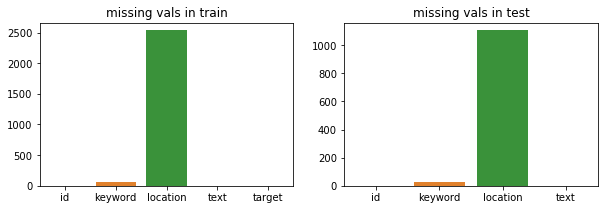

In [10]:
# using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
sns.barplot(x =missing_vals.index, y = missing_vals.values, ax=ax1)
ax1.set_title('missing vals in train')
sns.barplot(x =test.isnull().sum().index, y = test.isnull().sum().values, ax=ax2)
ax2.set_title('missing vals in test')
plt.show()

In [11]:
train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [12]:
# key word distribution for target
train.groupby('target')['keyword'].count()

target
0    4323
1    3229
Name: keyword, dtype: int64

In [13]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Target distribution for either classes
   * Mean value of 1 means: the keyword occurs only in class '1'
   * Mean value of 0 means: the keyword occurs only in class '0'
   * Anything in between means it occurs in both classes

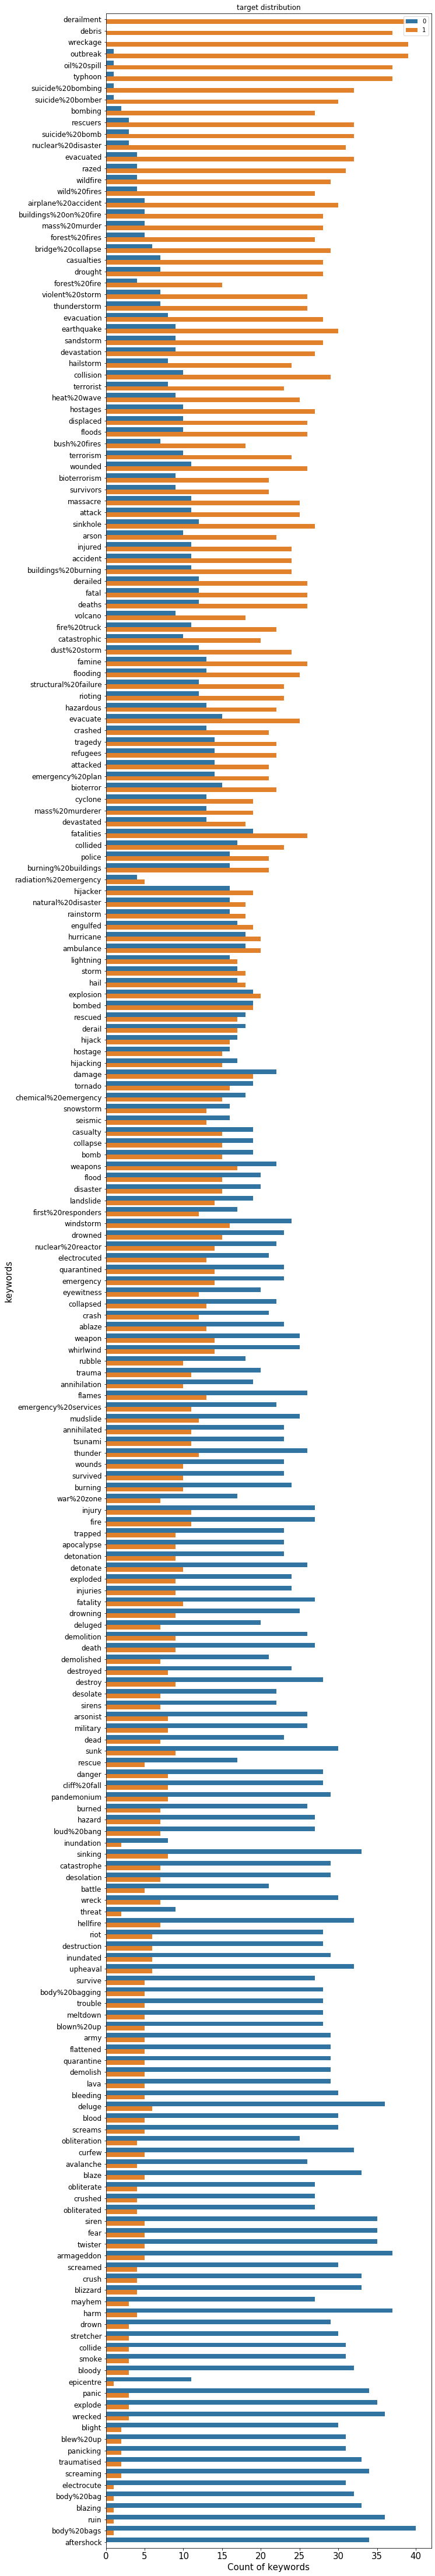

In [14]:
# mean count for each unique word
#train.groupby('keyword')['target'].first()
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')
#train.dropna()

# Count plot
plt.figure(figsize=(10, 80))
sns.countplot(y = train.sort_values('target_mean', ascending=False)['keyword'], 
             hue = train.sort_values('target_mean', ascending=False)['target']
             )
plt.xlabel('Count of keywords', fontsize=15)
plt.ylabel('keywords', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.title('target distribution')
plt.legend(loc='upper right')
plt.show()

### 2.1 Exploring the most frequently use words in either classes separately

In [15]:
train1 = train[train['target']==1]
train0 = train[train['target']==0]

In [19]:
train1.head(5)

,id,keyword,location,text,target,target_mean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN


In [54]:
# Ref: http://www.locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/

from collections import defaultdict
from nltk.corpus import stopwords
stop = stopwords.words('english')

def generate_ngrams(text, n_gram=1):
    tokens = [token for token in text.lower().split() if token != "" if token not in stop and len(token) > 1]    
    # generate n_grams
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    # join all the ngrams
    return [" ".join(ngram) for ngram in ngrams]


def plot_bar(df, color):
    trace = go.Bar(
                    y = df['word'].values[::-1],
                    x = df['frequency'].values[::-1],
                    orientation='h',
                    marker = dict(
                                color= color),
    )
    return trace
                 
freq_dict = defaultdict(int)
for sent in train1['text']:
    for word in generate_ngrams(sent):
        freq_dict[word]+=1
        
# create a dataframe
# sort the dictionary by the values
# Method: 1 create a dataframe and sort
#pd.DataFrame(freq_dict.items(), columns=['words', 'count']).sort_values('count', ascending=False).reset_index(drop=True)

# Method: 2 sort the dictionary and then create the dataframe
freq_sorted = pd.DataFrame(sorted(freq_dict.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])

trace = plot_bar(freq_sorted.head(50), 'red')
layout = go.Layout(title = 'Most frequent words in disaster tweets')
fig = go.Figure(trace, layout)
py.iplot(fig)
plt.show()

In [ ]:
temp ='Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
tokens = [w for w in temp.lower().split() if temp != "" if temp not in stop]
ngrams = zip(*[tokens[i:] for i in range(2)])
[" ".join(ngram) for ngram in ngrams]

## 3. Meta features

In [ ]:
train